In [1]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(2048)
environ['n_epochs']= '1000'
environ['batch_norm']= 'True'
environ['loss_func']='MSE'
environ['layers'] = '700 600 350 200 180'
environ['dropouts'] = '0.5 '*5
environ['log'] = 'False'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:2'
environ['dataset'] = 'data/speedup_dataset2.pkl'

%run utils.ipynb

In [2]:
train_dl, val_dl, test_dl = train_dev_split(dataset, batch_size, num_workers, log=log)

db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

In [3]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)
    
if loss_func == 'MSE':
    criterion = nn.MSELoss()
else:
    criterion = mape_criterion

l = fai.Learner(db, model, loss_func=criterion, 
                metrics=[mape_criterion, rmse_criterion],
                callback_fns=[partial(EarlyStoppingCallback, mode='min', monitor='rmse_criterion', min_delta=0, patience=10)])

if optimizer == 'SGD':
    l.opt_func = optim.SGD

In [4]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [16]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


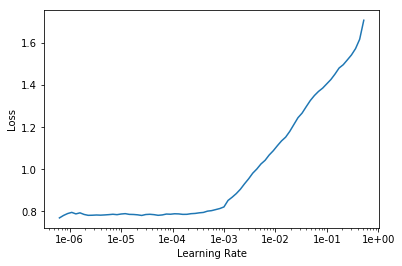

In [17]:
l.recorder.plot()

In [82]:
lr = 1e-4

In [83]:
l.fit_one_cycle(300, lr)

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,4.849150,5.495269,122.653526,2.343617
2,4.835202,5.502480,123.398476,2.345316
3,4.811011,5.492928,122.334023,2.342560
4,4.808527,5.485877,121.958702,2.340786
5,4.738709,5.477128,120.836021,2.339912
6,4.704393,5.466801,119.736588,2.337562
7,4.678386,5.459597,118.855034,2.336057
8,4.670320,5.436223,116.281425,2.331513
9,4.629016,5.420029,114.505165,2.327652
10,4.581708,5.386214,110.691460,2.320695


Epoch 195: early stopping


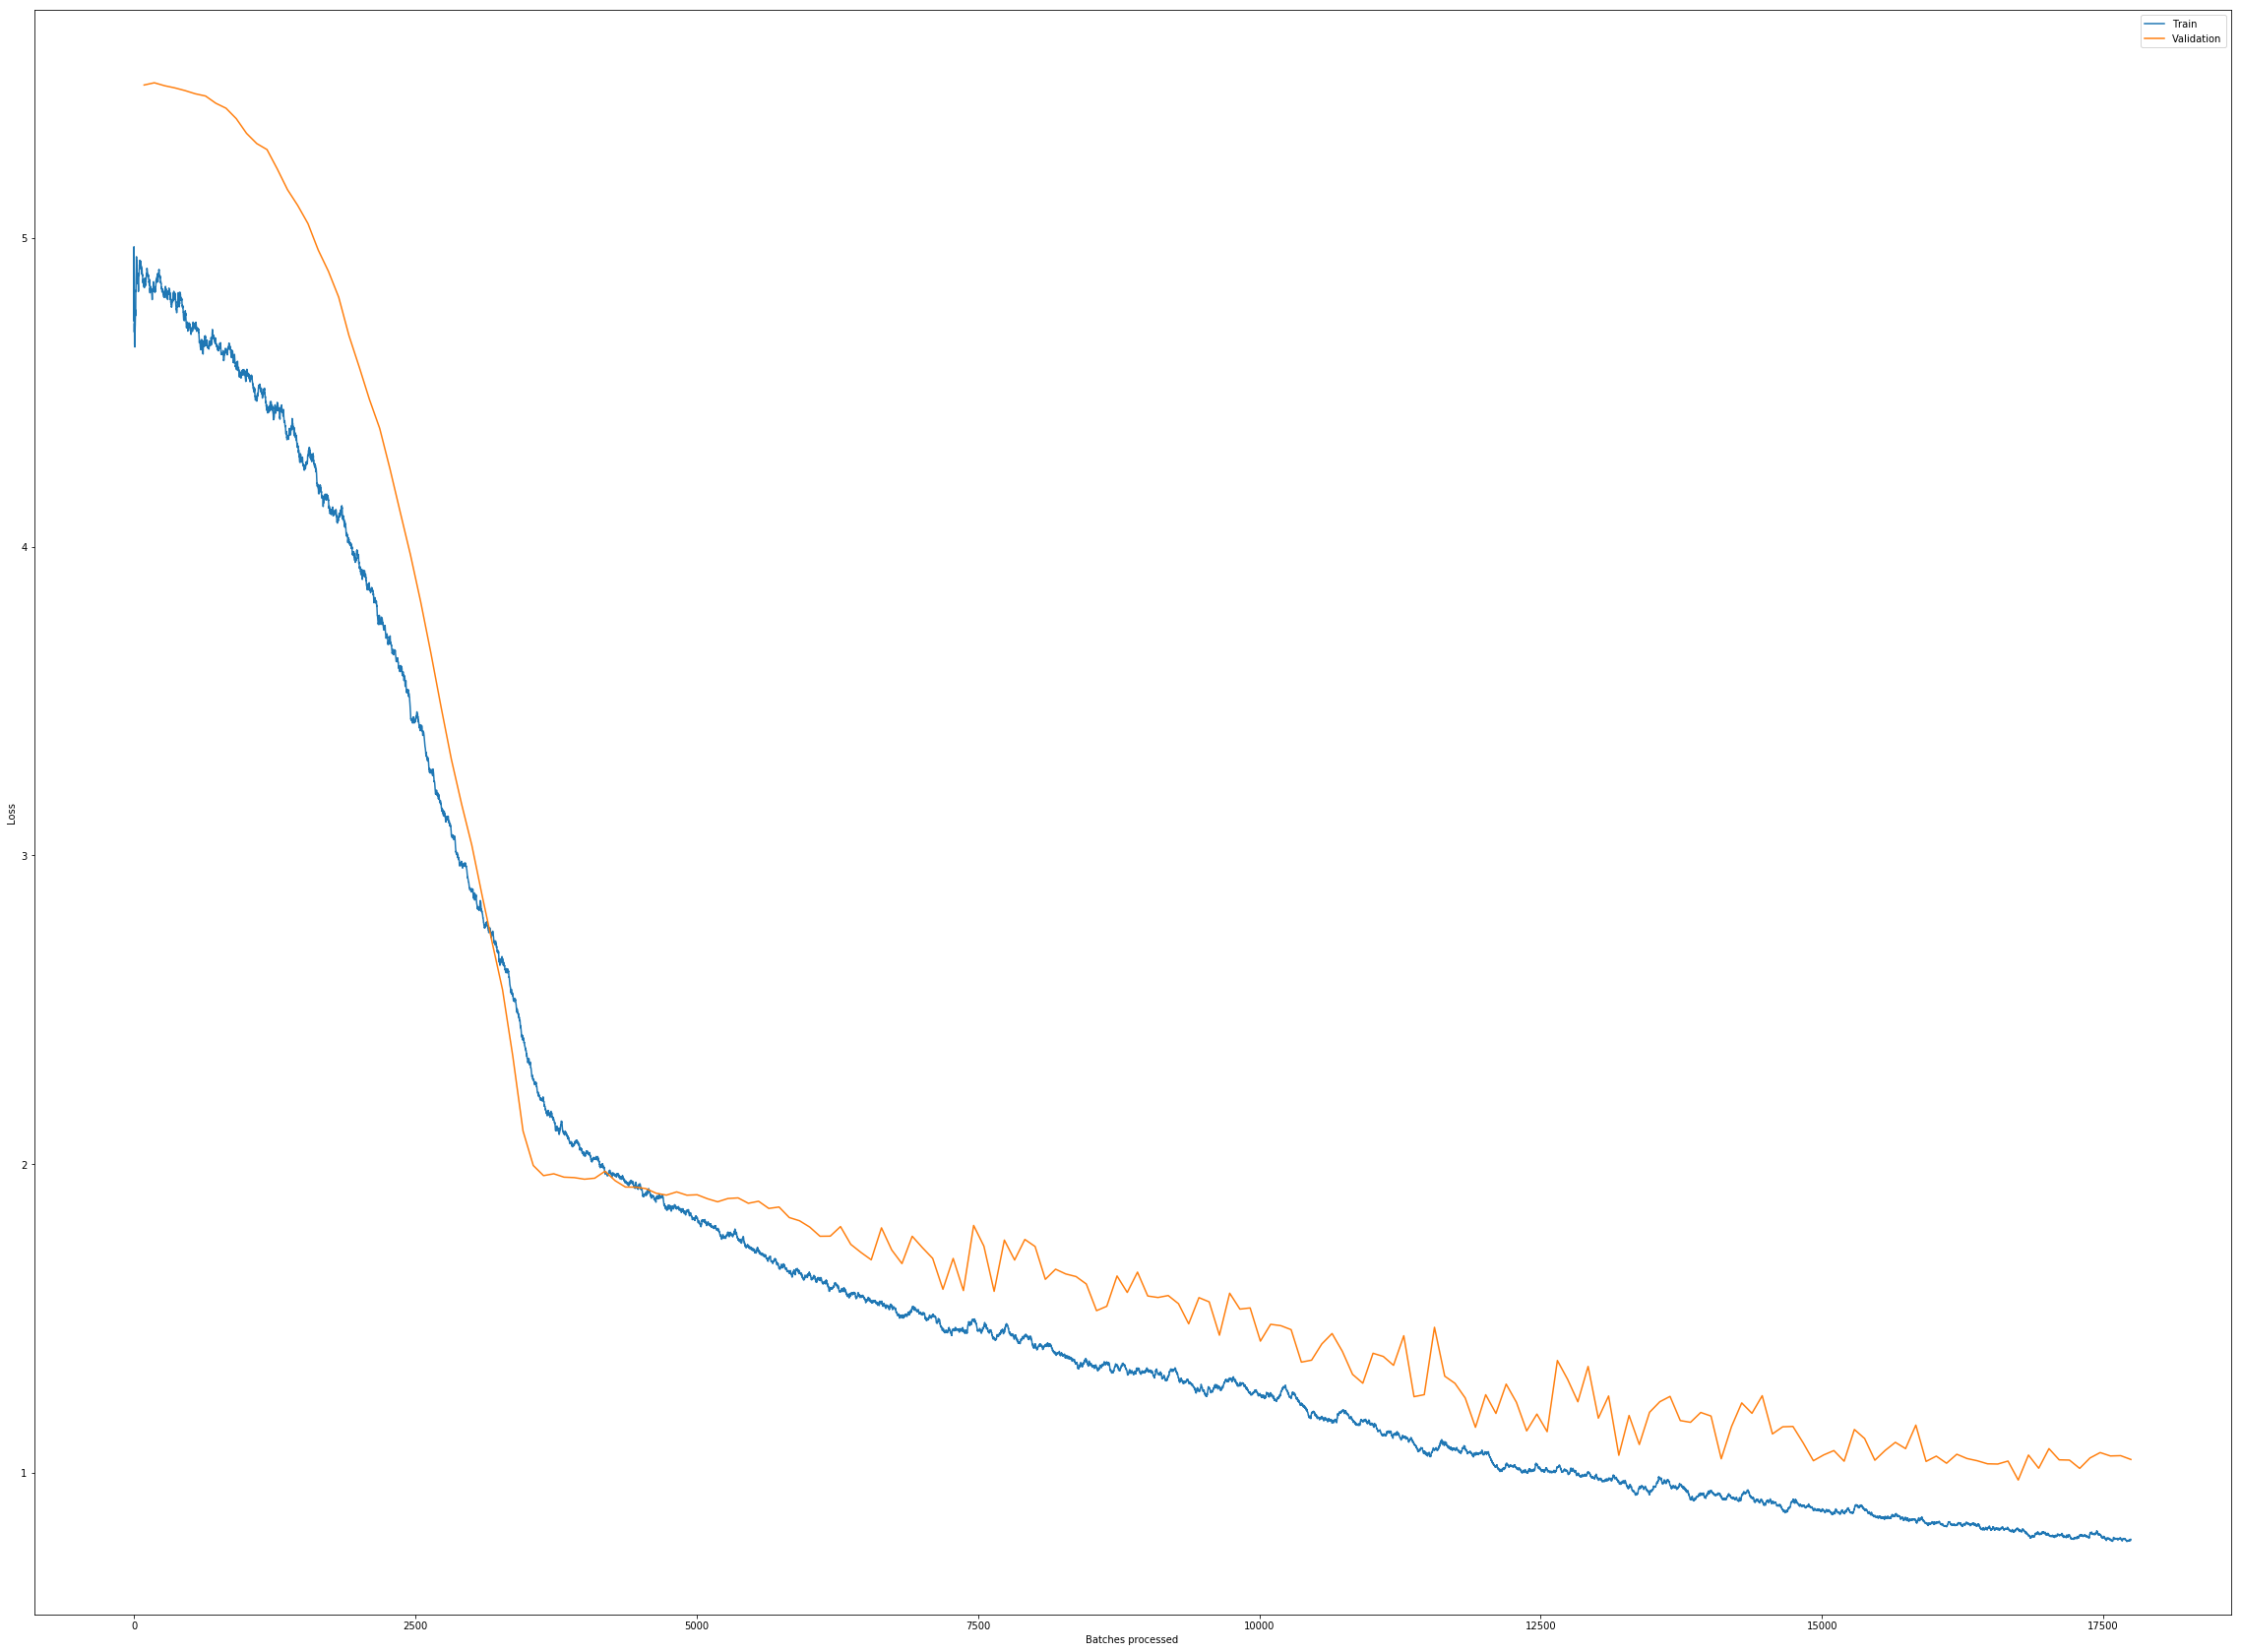

In [84]:
l.recorder.plot_losses()

In [85]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [20]:
"done"

'done'

In [5]:
val_df = get_results_df(val_dl, l.model)
train_df = get_results_df(train_dl, l.model)

In [6]:
df = val_df

In [90]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,185651.000000,185651.000000,185651.000000,185651.000000
mean,1.094639,1.184810,0.498368,160.315704
std,1.212444,1.613917,0.622952,341.550537
min,0.244995,0.008491,0.000017,0.001805
25%,0.337003,0.211613,0.154713,22.529292
50%,0.613558,0.565550,0.292336,48.972534
75%,1.312282,1.394052,0.606106,127.872387
max,7.475633,16.089287,14.893134,6498.653320


In [11]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,185651.000000,185651.000000,185651.000000,185651.000000
mean,1.094639,1.184810,0.498368,160.315704
std,1.212444,1.613917,0.622952,341.550537
min,0.244995,0.008491,0.000017,0.001805
25%,0.337003,0.211613,0.154713,22.529292
50%,0.613558,0.565550,0.292336,48.972534
75%,1.312282,1.394052,0.606106,127.872387
max,7.475633,16.089287,14.893134,6498.653320


In [159]:
df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,5272.000000,5272.000000,5272.000000,5272.000000
mean,5.139454,5.371452,0.573196,24.085110
std,2.129367,2.290008,0.491706,81.973442
min,0.541461,0.058317,0.000058,0.001177
25%,4.618636,3.869889,0.205381,4.140809
50%,5.469416,5.639095,0.451528,8.874032
75%,6.063024,6.547940,0.809658,15.718910
max,10.828941,13.560771,3.484350,828.611633


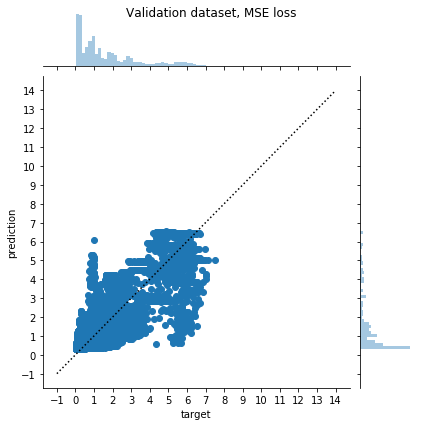

In [15]:
df1 = df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)]
#joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")

In [7]:
df_ = df.sort_values(by=["target"])

df_['x'] = range(len(df_))

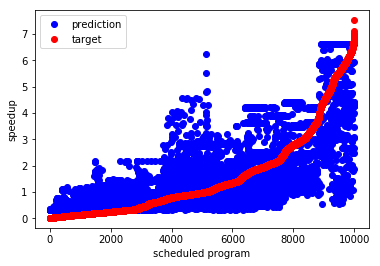

In [8]:
plt.plot('x', 'prediction', 'bo', data=df_)
plt.plot('x', 'target','ro', data=df_)

plt.xlabel('scheduled program')
plt.ylabel('speedup')
plt.legend()

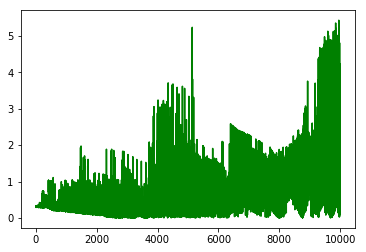

In [9]:
plt.plot('x', 'abs_diff', 'g-', data=df_)